# Fake News Detection using PassiveAggressiveClassifier with 6-Class Output

## Import Required Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Load the LIAR Dataset

In [8]:
# Define column names based on the LIAR dataset description
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

# Load the datasets
train_df = pd.read_csv('backend/dataset/liar_dataset/train.tsv', sep='\t', names=column_names)
valid_df = pd.read_csv('backend/dataset/liar_dataset/valid.tsv', sep='\t', names=column_names)
test_df = pd.read_csv('backend/dataset/liar_dataset/test.tsv', sep='\t', names=column_names)

In [9]:
# Display the first few rows to understand the data
train_df.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [10]:
# Basic information about the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   statement             10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   job_title             7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   party_affiliation     10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_counts      10238 non-null  float64
 11  mostly_true_counts    10238 non-null  float64
 12  pants_on_fire_counts  10238 non-null  float64
 13  context               10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


## Prepare 6-Class Labels

In [11]:
# We'll use LabelEncoder to convert text labels to numeric values
label_encoder = LabelEncoder()

# Fit the encoder on all possible labels
all_labels = pd.concat([train_df['label'], valid_df['label'], test_df['label']]).unique()
label_encoder.fit(all_labels)

# Transform the labels to numeric values
train_df['label_encoded'] = label_encoder.transform(train_df['label'])
valid_df['label_encoded'] = label_encoder.transform(valid_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Display the mapping from text labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:")
for label, code in label_mapping.items():
    print(f"{label}: {code}")

Label mapping:
barely-true: 0
false: 1
half-true: 2
mostly-true: 3
pants-fire: 4
true: 5


In [12]:
# Check the distribution of the 6 classes
print("Training set label distribution:")
print(train_df['label'].value_counts())
print("\nValidation set label distribution:")
print(valid_df['label'].value_counts())
print("\nTest set label distribution:")
print(test_df['label'].value_counts())

Training set label distribution:
label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

Validation set label distribution:
label
false          263
mostly-true    251
half-true      248
barely-true    237
true           169
pants-fire     116
Name: count, dtype: int64

Test set label distribution:
label
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: count, dtype: int64


## Data Preprocessing

In [13]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/abhishek-a/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abhishek-a/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abhishek-a/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Function for text preprocessing
def preprocess_text(text):
    # Convert to string if not already
    if not isinstance(text, str):
        text = str(text)
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join tokens back into a string
    clean_text = ' '.join(clean_tokens)
    
    return clean_text

In [15]:
# Apply preprocessing to all datasets
train_df['clean_statement'] = train_df['statement'].apply(preprocess_text)
valid_df['clean_statement'] = valid_df['statement'].apply(preprocess_text)
test_df['clean_statement'] = test_df['statement'].apply(preprocess_text)

In [16]:
# Display a few cleaned statements
pd.DataFrame({
    'Original': train_df['statement'].head(),
    'Cleaned': train_df['clean_statement'].head(),
    'Label': train_df['label'].head()
})

,Original,Cleaned,Label
0,Says the Annies List political group supports ...,say annies list political group support thirdt...,false
1,When did the decline of coal start? It started...,decline coal start started natural gas took st...,half-true
2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...,mostly-true
3,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...,false
4,The economic turnaround started at the end of ...,economic turnaround started end term,half-true


## Feature Extraction

In [17]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_df['clean_statement'])
y_train = train_df['label_encoded']  # Using the encoded 6-class labels

# Transform validation and test data
X_valid = tfidf_vectorizer.transform(valid_df['clean_statement'])
y_valid = valid_df['label_encoded']
X_test = tfidf_vectorizer.transform(test_df['clean_statement'])
y_test = test_df['label_encoded']

In [18]:
# Get feature names and show some top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Sample features: {feature_names[:20]}")

Number of features: 5000
Sample features: ['abbott' 'abele' 'ability' 'able' 'abolish' 'aborted' 'abortion'
 'abortion even' 'abortion illegal' 'abortion right' 'abraham'
 'abraham lincoln' 'absolutely' 'abuse' 'abuser' 'academic' 'academy'
 'accept' 'accepted' 'accepting']


## Model Training

In [19]:
# Initialize the Passive Aggressive Classifier
# For multi-class, we need to use 'ovr' (one-vs-rest) or 'crammer_singer' for multi-class strategy
pac = PassiveAggressiveClassifier(max_iter=50, loss='squared_hinge', class_weight='balanced')

# Train the model
pac.fit(X_train, y_train)

/home/abhishek-a/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


PassiveAggressiveClassifier(class_weight='balanced', loss='squared_hinge',
                            max_iter=50)

## Model Evaluation

Validation Accuracy: 0.2165


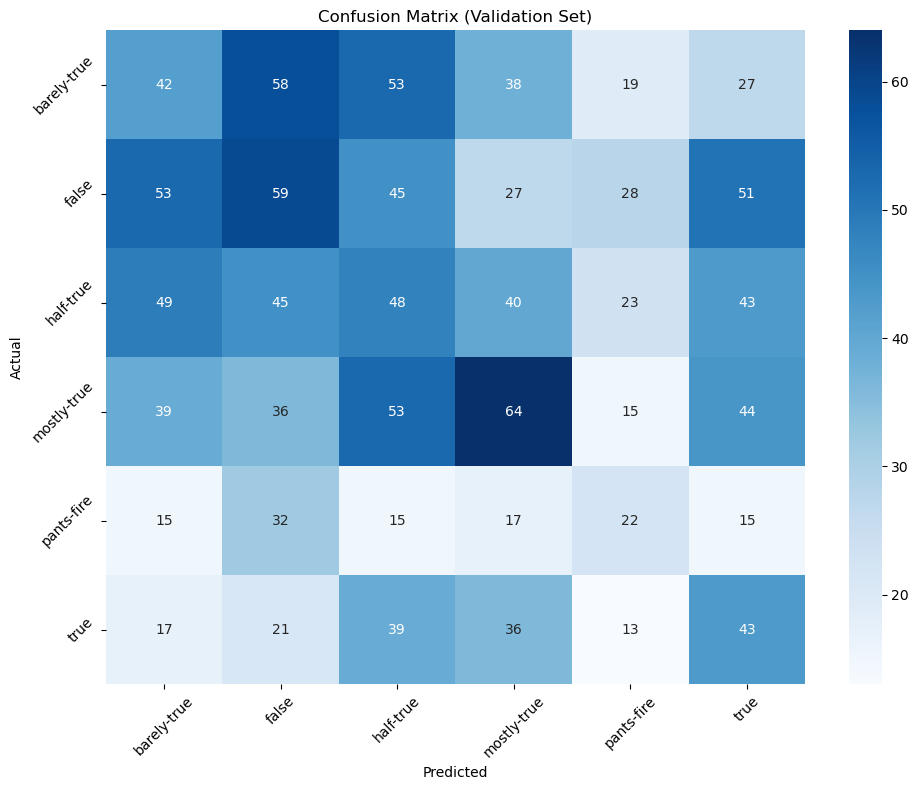


Classification Report (Validation Set):
              precision    recall  f1-score   support

 barely-true       0.20      0.18      0.19       237
       false       0.24      0.22      0.23       263
   half-true       0.19      0.19      0.19       248
 mostly-true       0.29      0.25      0.27       251
  pants-fire       0.18      0.19      0.19       116
        true       0.19      0.25      0.22       169

    accuracy                           0.22      1284
   macro avg       0.21      0.22      0.21      1284
weighted avg       0.22      0.22      0.22      1284



In [20]:
# Make predictions on the validation set
y_valid_pred = pac.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report (Validation Set):")
print(classification_report(y_valid, y_valid_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.2234


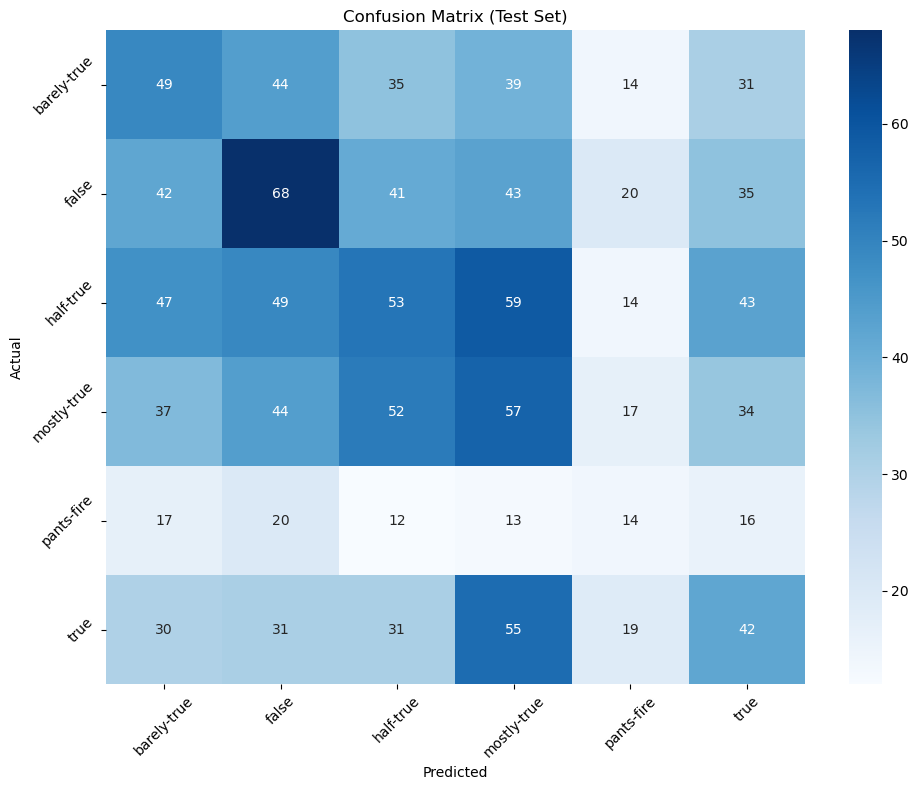


Classification Report (Test Set):
              precision    recall  f1-score   support

 barely-true       0.22      0.23      0.23       212
       false       0.27      0.27      0.27       249
   half-true       0.24      0.20      0.22       265
 mostly-true       0.21      0.24      0.22       241
  pants-fire       0.14      0.15      0.15        92
        true       0.21      0.20      0.21       208

    accuracy                           0.22      1267
   macro avg       0.21      0.22      0.21      1267
weighted avg       0.22      0.22      0.22      1267



In [21]:
# Make predictions on the test set
y_test_pred = pac.predict(X_test)

# Evaluate the model on test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate confusion matrix for test data
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report for test data
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

## Feature Importance Analysis

In [22]:
# Get the feature importance from model coefficients for each class
# For multi-class, we have a coefficient for each feature for each class
coef_df_list = []

# For each class, create a DataFrame of feature importances
for i, class_name in enumerate(label_encoder.classes_):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        f'Importance_{class_name}': pac.coef_[i]
    })
    
    # Sort by absolute importance
    feature_importance[f'Abs_Importance_{class_name}'] = np.abs(feature_importance[f'Importance_{class_name}'])
    feature_importance = feature_importance.sort_values(f'Abs_Importance_{class_name}', ascending=False)
    
    # Display top features for this class
    print(f"Top 10 features for class '{class_name}':")
    print(feature_importance[[f'Feature', f'Importance_{class_name}']].head(10))
    print("\n")
    
    # Store for later use
    coef_df_list.append(feature_importance.head(10))

Top 10 features for class 'barely-true':
                Feature  Importance_barely-true
4444          tennessee              -15.272451
4169      spent million              -12.336478
2362    license illegal               11.520020
2578       member house              -11.324293
2888     oil production              -11.289579
1418             extend              -11.221596
4946        year budget               11.087687
4337  support obamacare              -10.950600
4893        woman right              -10.858799
4155        spend money              -10.686447


Top 10 features for class 'false':
               Feature  Importance_false
4875      wisconsinite         11.838449
1092         destroyed         11.609774
3855          say many         11.198386
2684             motor         10.828488
1299  employer mandate        -10.826487
4222         state law        -10.419977
570   capandtrade bill        -10.405735
704          clackamas         10.367236
3795     sanction iran   

/tmp/ipykernel_41092/1555730941.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'Importance_{class_name}', y='Feature', data=df.head(8), ax=axes[i], palette='viridis')
/tmp/ipykernel_41092/1555730941.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'Importance_{class_name}', y='Feature', data=df.head(8), ax=axes[i], palette='viridis')
/tmp/ipykernel_41092/1555730941.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'Importance_{class_name}', y='Feature', data=df.head(8), ax=axes[i], palette='viridis')
/tmp/ipykernel_41092/1

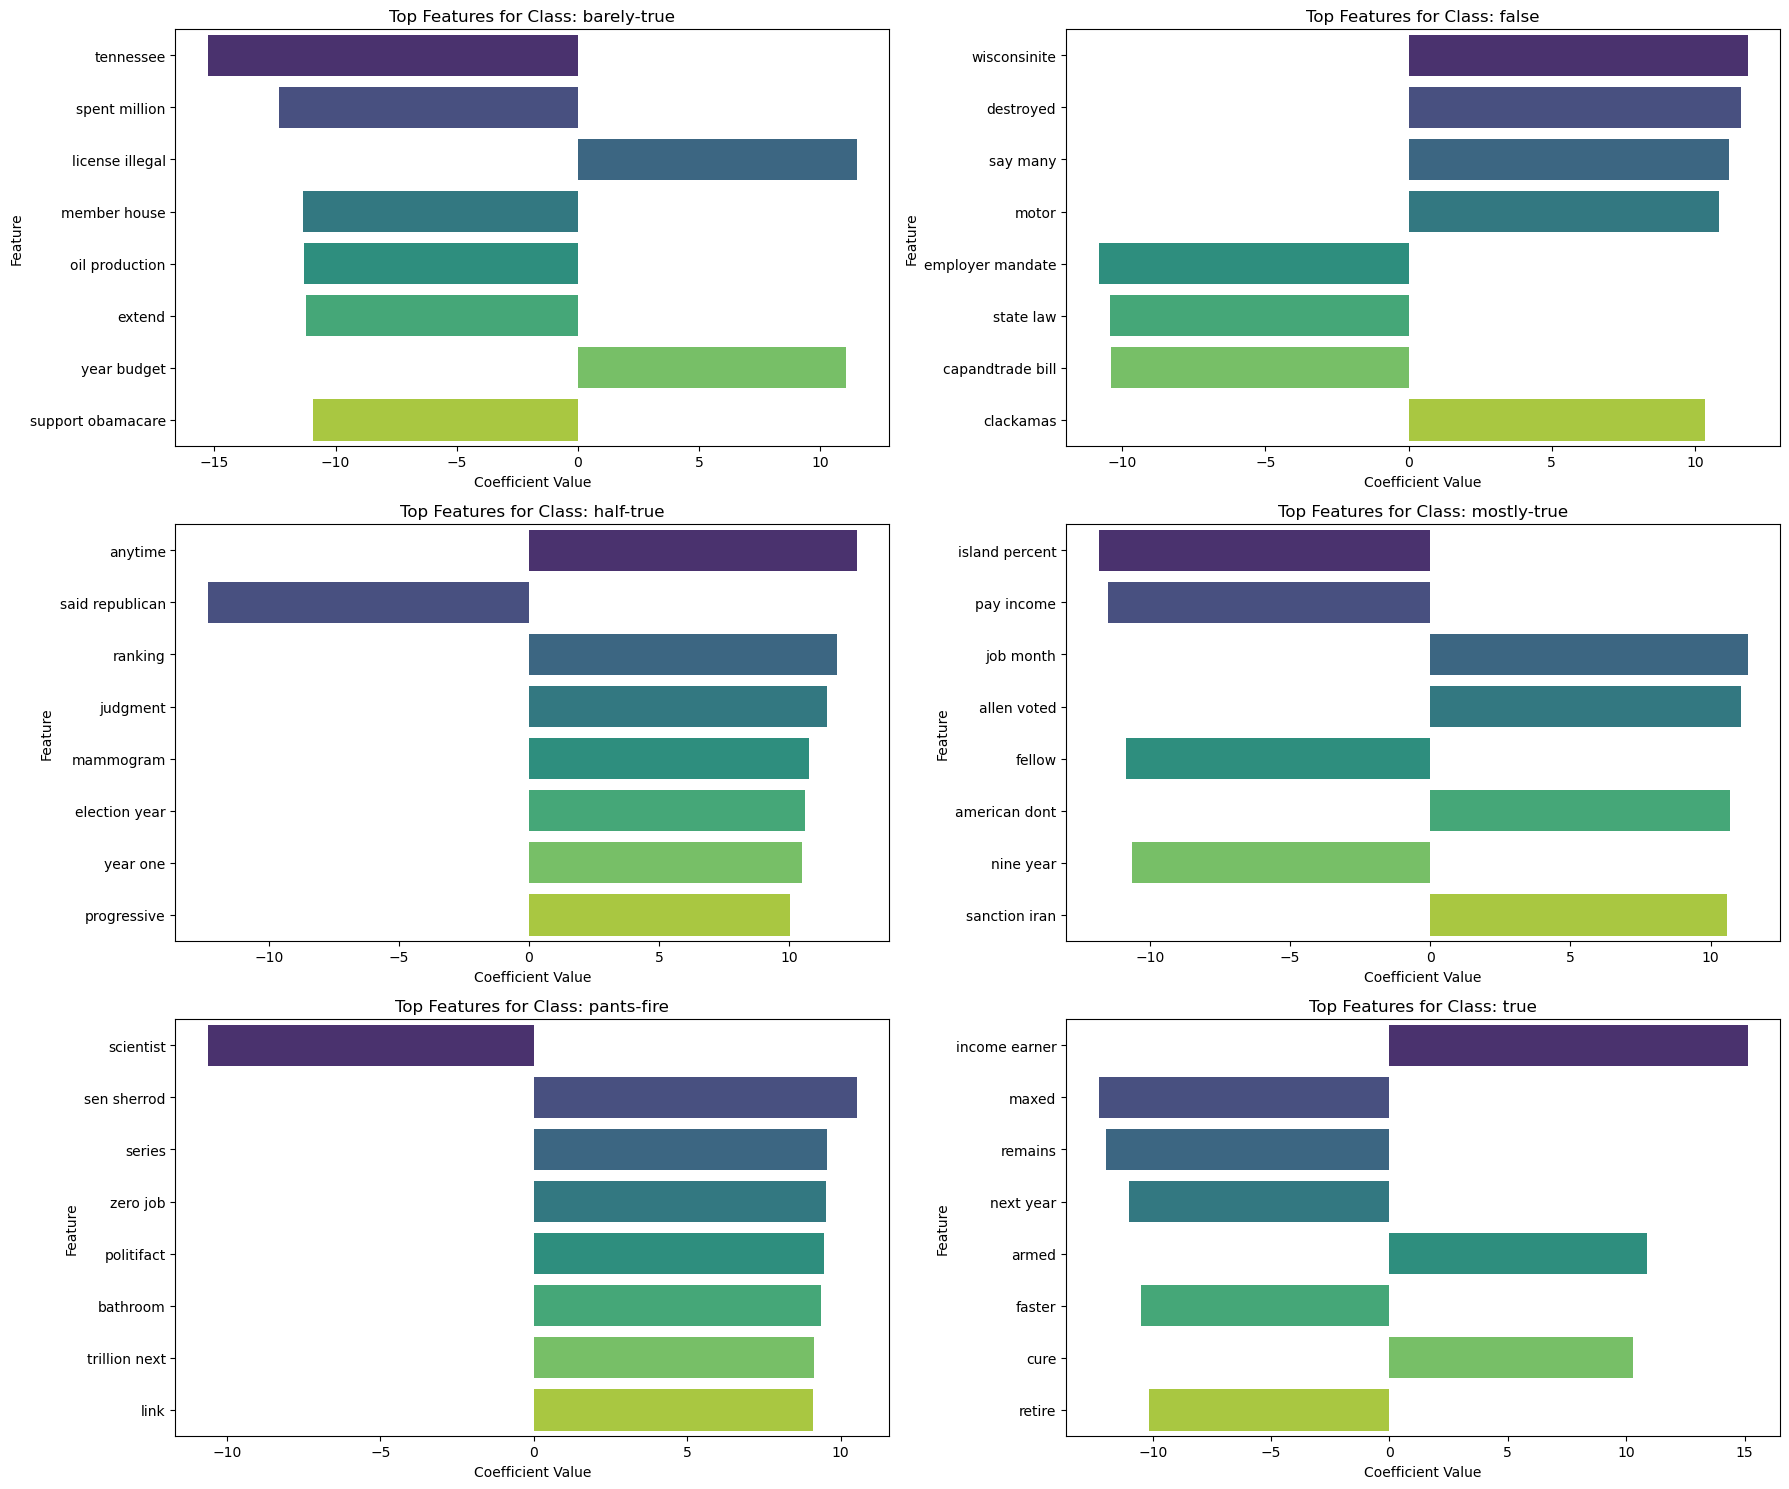

In [23]:
# Visualize top features for each class
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for i, class_name in enumerate(label_encoder.classes_):
    df = coef_df_list[i]
    sns.barplot(x=f'Importance_{class_name}', y='Feature', data=df.head(8), ax=axes[i], palette='viridis')
    axes[i].set_title(f'Top Features for Class: {class_name}')
    axes[i].set_xlabel('Coefficient Value')
    
plt.tight_layout()
plt.show()

## Save the Model

In [24]:
import pickle

# Save the model
with open('model_6class.pkl', 'wb') as model_file:
    pickle.dump(pac, model_file)

# Save the vectorizer
with open('vector_6class.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)
    
# Save the label encoder
with open('label_encoder_6class.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print("Model, vectorizer, and label encoder saved successfully!")

Model, vectorizer, and label encoder saved successfully!


## Prediction Function for 6-Class Output

In [25]:
# Function to predict the truthfulness category of a statement
def predict_truthfulness(statement):
    # Preprocess the statement
    clean_statement = preprocess_text(statement)
    
    # Transform using the vectorizer
    statement_vector = tfidf_vectorizer.transform([clean_statement])
    
    # Make prediction (returns the encoded class)
    predicted_class_encoded = pac.predict(statement_vector)[0]
    
    # Convert the encoded class back to the original label
    predicted_class = label_encoder.inverse_transform([predicted_class_encoded])[0]
    
    # Get probability scores for all classes if the model supports it
    # Note: PassiveAggressiveClassifier doesn't have predict_proba, so we'll use decision_function
    decision_scores = pac.decision_function(statement_vector)[0]
    
    # Create a dictionary of class scores
    class_scores = {}
    for i, class_name in enumerate(label_encoder.classes_):
        class_scores[class_name] = decision_scores[i] if len(decision_scores.shape) > 0 else decision_scores
    
    return predicted_class, class_scores

# Test with some sample statements
sample_statements = [
    "NASA Astronauts Sunita Williams and Butch Wilmore have successfully landed back on Earth after a nine-month space mission.",
    "Climate change is a hoax invented by scientists to get research funding.",
    "The Nifty 50 is poised to break its longest losing monthly streak in years, while the Sensex has soared 4% in March.",
    "The average family saves $5,000 per year under the new healthcare plan.",
    "In February 2025, US Border Patrol logged 8,326 encounters with migrants at the southern border with Mexico."
]

for i, statement in enumerate(sample_statements):
    predicted_class, class_scores = predict_truthfulness(statement)
    print(f"Sample {i+1}: {statement}")
    print(f"Predicted Class: {predicted_class}")
    
    # Print scores for each class
    print("Class Scores:")
    for class_name, score in class_scores.items():
        print(f"  {class_name}: {score:.4f}")
    print("\n")

Sample 1: NASA Astronauts Sunita Williams and Butch Wilmore have successfully landed back on Earth after a nine-month space mission.
Predicted Class: half-true
Class Scores:
  barely-true: -2.3070
  false: 0.2429
  half-true: 3.1989
  mostly-true: -6.6198
  pants-fire: -3.9136
  true: 1.0763


Sample 2: Climate change is a hoax invented by scientists to get research funding.
Predicted Class: mostly-true
Class Scores:
  barely-true: -2.5283
  false: 0.6787
  half-true: -2.9903
  mostly-true: 1.0576
  pants-fire: -10.2379
  true: -1.4476


Sample 3: The Nifty 50 is poised to break its longest losing monthly streak in years, while the Sensex has soared 4% in March.
Predicted Class: false
Class Scores:
  barely-true: -1.1195
  false: 0.3161
  half-true: -4.3736
  mostly-true: -3.0740
  pants-fire: -1.4576
  true: -5.9165


Sample 4: The average family saves $5,000 per year under the new healthcare plan.
Predicted Class: barely-true
Class Scores:
  barely-true: 0.6399
  false: -3.7110
  hal